# Project III: Semi-supervised Learning Topic Modelling with Anchored CorEx

In the last project, I performed unsupervised topic classification primarily using Latent Dirichlet Allocation (LDA). LDA was successfully able to generate topics for Herman Hesse's book Siddharta. However, understanding the words that made up the topics was very difficult. There were some topics that had extremely correlated words like `heart` and `kamala` which refer to love and there were topic words that were extremely difficult to put together such as `said` and `path`. These showed the disadvantage of unsupervised learning in that while it is able to come up with relationships about the data, it remains up to the user to determine the meaning behind these relationships. 

In an effort to address this disadvantage, I perform Semi-Supervised Topic Modelling using [Anchored CorEx](https://github.com/gregversteeg/corex_topic) in this project. [Semi-supervised machine learning](https://machinelearningmastery.com/what-is-semi-supervised-learning/) is a type of machine learning which includes a small number of labelled data and a larger number of unlabelled observations. The small number of labelled data I use in this project comes in the form of `anchor words`. Anchor words are words provided by the user to the corEx model in order to guide the model to learning information related to those anchor words. Anchoring is a good way of gearing the model towards certain explorations and it allows the user to be flexible and fully explore all the possible topics in a text. 

For the text I will use, I continue to use Herman Hesse's Siddharta from Project Gutenburg. I attempt to improve my results from the unsupervised method by provide anchor words geared towards the theme of the book. Let's begin.

## Table of Contents
I. [Importing Libraries and Installing External Dependencies](#s1) <br>
II. [Data Collection and Preprocessing](#s2) <br>
III. [Semi-supervised Modelling with Anchored CorEx](#s3) <br>
IV. [Visualizing Text with Word2Vec](#s4) <br>
V. [Comparing Results with Unsupervised Modelling](#s5) <br>
VI. [Conclusions and Recommendations](#s6) <br>

### Importing Libraries and Installing External Dependencies <a name="s1"></a>

In [1]:
# Necessary pip install of external libraries
!pip install gutenberg
!pip install gutenberg-cleaner
!pip install pyLDAvis
!pip install corextopic
!pip install imageio

     |████████████████████████████████| 67 kB 2.5 MB/s 
     |████████████████████████████████| 230 kB 36.2 MB/s 
     |████████████████████████████████| 437 kB 42.6 MB/s 
     |████████████████████████████████| 239 kB 35.3 MB/s 
     |████████████████████████████████| 237 kB 30.1 MB/s 
     |████████████████████████████████| 242 kB 35.7 MB/s 
     |████████████████████████████████| 240 kB 36.7 MB/s 
     |████████████████████████████████| 239 kB 39.0 MB/s 
     |████████████████████████████████| 326 kB 33.0 MB/s 
     |████████████████████████████████| 228 kB 7.5 MB/s 
     |████████████████████████████████| 325 kB 20.0 MB/s 
     |████████████████████████████████| 236 kB 34.6 MB/s 
     |████████████████████████████████| 563 kB 34.3 MB/s 
     |████████████████████████████████| 450 kB 14.5 MB/s 
     |████████████████████████████████| 456 kB 11.0 MB/s 
     |████████████████████████████████| 340 kB 35.2 MB/s 
     |████████████████████████████████| 482 kB 35.3 MB/s 
     |███████████

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import urllib
import urllib.request
import pyLDAvis.sklearn
import os
import imageio
from matplotlib.axes._axes import _log as matplotlib_axes_logger

% matplotlib inline

# NLP preprocessing libraries
import nltk
nltk.download('punkt')
import gensim
import re
import string
import unicodedata
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords
import scipy.sparse as ss

# ML libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# gutenberg cleaning libraries
from gutenberg.cleanup import strip_headers
from gutenberg_cleaner import super_cleaner

#corEx
import corextopic.corextopic as ct
import corextopic.vis_topic as vt 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



## Data Collection and Preprocessing <a name="s2"></a>


In [4]:
# Siddharta Project Gutenburg URL
url = "https://www.gutenberg.org/cache/epub/2500/pg2500.txt"

response = urllib.request.urlopen(url)
raw = response.read()
text = raw.decode("utf-8-sig")

print(text)

The Project Gutenberg eBook of Siddhartha, by Herman Hesse

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Siddhartha

Author: Herman Hesse

Translator: Gunther Olesch, Anke Dreher, Amy Coulter, Stefan Langer and Semyon Chaichenets

Release Date: February, 2001 [eBook #2500]
[Most recently updated: December 22, 2021]

Language: English


Produced by: Michael Pullen, Chandra Yenco and Isaac Jones

*** START OF THE PROJECT GUTENBERG EBOOK SIDDHARTHA ***




Siddhartha

An Indian Tale


by Herman Hesse




Contents


 FIRST PART
 THE SON OF THE BRAHMAN
 WITH THE SAMANAS
 GOTAMA
 AWAKENING

 S

As can be seen from the first print-out of the text. There are many unneccesary sections in the entire ebook. This includes Project Gutenburg footers and headers, as well as book titles and chapters. 

In order to alleviate the work in performing data cleaning, I use the libraries [gutenberg](https://github.com/ageitgey/Gutenberg) and [gutenberg_cleaner](https://github.com/kiasar/gutenberg_cleaner) to perform footer and header cleaning as well as necessary chapters titles, and book titles cleaning. 

In [5]:
# Removing gutenburg related headers and footers
text = strip_headers(text).strip()

# Removing chapter titles and book titles
text = super_cleaner(text)

Super cleaner replaces the deleted texts with `"deleted"` so we replace all those with `""`.

In [6]:
text = text.replace("[deleted]", "")

print(text)



















To Romain Rolland, my dear friend






In the shade of the house, in the sunshine of the riverbank near the
boats, in the shade of the Sal-wood forest, in the shade of the fig
tree is where Siddhartha grew up, the handsome son of the Brahman, the
young falcon, together with his friend Govinda, son of a Brahman. The
sun tanned his light shoulders by the banks of the river when bathing,
performing the sacred ablutions, the sacred offerings. In the mango
grove, shade poured into his black eyes, when playing as a boy, when
his mother sang, when the sacred offerings were made, when his father,
the scholar, taught him, when the wise men talked. For a long time,
Siddhartha had been partaking in the discussions of the wise men,
practising debate with Govinda, practising with Govinda the art of
reflection, the service of meditation. He already knew how to speak the
Om silently, the word of words, to speak it silently into himself while
inhaling, to speak it silently out of hi

Now we have successfully extracted a cleaner version of the Gutenburg text. We now move on to perform data cleaning by removing urls, usernames, punctuations, hashtags, emojis, and performing lemmatization. 

In [7]:
# Create functions for cleaning text

def remove_url(text):
  return text.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')

def remove_url_2(text):
  return re.sub(r'http\S+', '', text)

def remove_twitter_handles(text):
  return re.sub("@[A-Za-z0-9]+", "", text)

def remove_usernames_links(text):
  text = re.sub('@[^\s]+','',text)
  text = re.sub('http[^\s]+','',text)
  return text

def remove_punctuations(text):
  additional_punctuations = ['’', '…'] # punctuations not in string.punctuation
  for punctuation in string.punctuation:
      text = text.replace(punctuation, '')
    
  for punctuation in additional_punctuations:
      text = text.replace(punctuation, '')
      
  return text

def remove_hashtags(text):
  return re.sub("#[A-Za-z0-9_]+","", text)

def remove_emojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
  
  return emoji_pattern.sub(r'', text)

# Stemming, Lemmatization, and stopwords removal
stemmer = SnowballStemmer('english')
nltk.download('wordnet')

def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='n')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize(token))
    return str(result)

# For returning lemmatized text as a list instead of a string
def preprocess_list(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize(token))
    return result

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
# Final data cleaning function
def clean_text(text, as_list=False):
  text = remove_twitter_handles(text)
  text = remove_hashtags(text)
  text = remove_url(text)
  text = remove_url_2(text)
  text = remove_punctuations(text)
  text = remove_emojis(text)
  text = remove_stopwords(text)
  text = text.lower()
  if as_list == False:
    text = preprocess(text)
  elif as_list == True:
    text = preprocess_list(text)
    
  return text

In [9]:
text_list = nltk.tokenize.sent_tokenize(text)
text_list = pd.Series(text_list)
clean_text = text_list.map(clean_text)

In [10]:
pd.set_option('max_colwidth', None)
clean_text[:5]

0    ['romain', 'rolland', 'dear', 'friend', 'shade', 'house', 'sunshine', 'riverbank', 'near', 'boat', 'shade', 'salwood', 'forest', 'shade', 'fig', 'tree', 'siddhartha', 'grew', 'handsome', 'son', 'brahman', 'young', 'falcon', 'friend', 'govinda', 'son', 'brahman']
1                                                                                                                                              ['sun', 'tanned', 'light', 'shoulder', 'bank', 'river', 'bathing', 'performing', 'sacred', 'ablution', 'sacred', 'offering']
2                                                                                                   ['mango', 'grove', 'shade', 'poured', 'black', 'eye', 'playing', 'boy', 'mother', 'sang', 'sacred', 'offering', 'father', 'scholar', 'taught', 'wise', 'men', 'talked']
3                                                                                        ['long', 'time', 'siddhartha', 'partaking', 'discussion', 'wise', 'men', 'practising', 'debate', 'govinda',

We now have a clean, lemmatized version of our text. 
We now move to semi-supervised modelling with Anchored CorEx. 

## Semi-supervised Modelling with Anchored CorEx <a name="s3"></a>

In order to use this model, I have to use anchor words and in order to determine the best possible anchor words, I consult the internet for summaries of themes in the book Siddharta. According to this [article](https://literarydevices.net/siddhartha-themes/), there are ten themes in Siddharta namely:
1. Enlightenment
2. Love
3. Cycles of Life
4. Search for Reality
5. Search for Satisfaction
6. Spirituality
7. Significance of Language and Communication
8. Time
9. Mortality
10. Parental Love

Given these ten key themes, I first begin by using ten achor words inspired from the ten themes namely: `enlightenment`, `love`, `cycles`, `reality`, `satisfaction`, `spirituality`, `communication`, `time`, `mortal`, `parent`. I first try out the CorEx model, analyze its results and then determine whether I can reduce the necessary anchor words and topics generated.   

### Anchored CorEx with CountVectorizer

In [11]:
# Create list of anchor words
anchor_words = ["enlightenment", "love", "cycles", "reality", "satisfaction", "spirituality", "communication", "time", "mortal", "parent"]

# Vectorizer
vectorizer = CountVectorizer(stop_words='english', binary=True)
doc_word = vectorizer.fit_transform(clean_text)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(1568, 3030)

In [12]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

As in the lecture, we'll do a final step of preprocessing where we remove all integers from our set of words.

In [13]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(1568, 3030)

First let's train an unsupervised CorEx model to see how it initially performs without anchoring. 

In [14]:
model = ct.Corex(n_hidden=5, words=words, max_iter=200, verbose=False, seed=42)
model.fit(doc_word, words=words)

Now let's check the list of words for the topics it discovered. 

In [15]:
# Print the topic from CorEx topic model
for i in range(len(model.get_topics())):
  print(model.get_topics(topic=i, n_words=5))

[('sky', 0.017977896829243542, 1.0), ('drink', 0.014288688938653885, 1.0), ('moon', 0.014288442952591102, 1.0), ('shadow', 0.012449752292774913, 1.0), ('piece', 0.010614566852277914, 1.0)]
[('face', 0.020817080650253905, 1.0), ('sound', 0.016228793568496085, 1.0), ('disgust', 0.016228793568496085, 1.0), ('thirst', 0.012753710703895074, 1.0), ('world', 0.011648472303092638, 1.0)]
[('young', 0.02336103549634273, 1.0), ('yellow', 0.019344574150614233, 1.0), ('saw', 0.018111013639608636, 1.0), ('buddha', 0.01801719766634818, 1.0), ('town', 0.01781708134096786, 1.0)]
[('time', 0.07571345231385548, 1.0), ('long', 0.055762337849769715, 1.0), ('siddhartha', 0.021579208645942743, 1.0), ('old', 0.021344720719741982, 1.0), ('eye', 0.020961882342992077, 1.0)]
[('money', 0.024843929808455175, 1.0), ('game', 0.02125658094132555, 1.0), ('sansara', 0.015453916186968179, 1.0), ('merchant', 0.015134063018565822, 1.0), ('innermost', 0.014008943989094132, 1.0)]


After inspection, it still is difficult to find a common theme across these topic words. The clearest would be the second topic which perhaps relates to the theme `reality` but the other sets of words are definitely unclear. 

Now, let's try doing the model with anchoring!

In [16]:
anchored_model_cv = ct.Corex(n_hidden=10, seed=42)
anchored_model_cv.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=4)

Since the model shows that three of our anchor words do not belong in our corpus, I'll cut down our anchor words cycles and communication and replace the word satisfaction with `happiness`.

In [17]:
# Create new list of anchor words
anchor_words = ["enlightenment", "love", "reality", "happiness", "spirituality", "time", "mortal", "parent"]

In [18]:
anchored_model_cv = ct.Corex(n_hidden=10, seed=42)
anchored_model_cv.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=4)

Now let's check the results by printing out the list of words per topic. 

In [19]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_model_cv.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: teaching, enlightenment, gotama, buddha, exalted, oh, govinda, samanas, venerable, quoth
1: love, water, act, stone, veneration, rock, worthy, bent, shone, leaf
2: priest, brahman, samana, fig, garment, pretty, sloth, afraid, drop, satisfied
3: world, happiness, pain, childlike, suffering, life, sens, thirst, oneness, form
4: siddhartha, inside, despair, deep, blue, body, tasted, rushing, window, mountain
5: time, long, ago, past, real, quiet, set, harvest, bright, thousand
6: innermost, yellow, tree, mortal, year, old, robe, self, goal, hidden
7: eye, saw, face, looked, hair, stood, shoe, bank, clothes, grown


After a quick inspection, we can immediately find that three of these topics can be more easily understood! 

`Topic 0: teaching, enlightenment, gotama, buddha, exalted, oh, govinda, samanas, venerable, quoth` undoubtedly relates to `enlightenment` as Siddharta's journey for it led him to become the `gotama buddha` along with his bestfriend `govinda`. The other words `exalted`, `oh`, `venerable` are expressions related to reaching enlightenment whereas the `samanas` are an ascetic group that aimed to reach enlightenment or self-actualization`. 

`Topic 3: world, happiness, pain, childlike, suffering, life, sens, thirst, oneness, form` relates to the dichotomy of happiness and suffering greatly explored by the book. 

`Topic 5: time, long, ago, past, real, quiet, set, harvest, bright, thousand` relates to notions of time. 

Already we see that with anchoring, the model was able to create a much more explainable set of results. 

Before I move on to optimizing the anchor_words, I first try the same model with TFIDF and word2vec. 

### Anchored CorEx with TfidfVectorizer

In [20]:
# Vectorizer
tfidf = TfidfVectorizer(stop_words='english', binary=True)
doc_word = tfidf.fit_transform(clean_text)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(1568, 3030)

In [21]:
# Create new list of anchor words
anchor_words = ["enlightenment", "love", "reality", "happiness", "spirituality", "time", "mortal", "parent"]

anchored_model_tfidf = ct.Corex(n_hidden=10, seed=42)
anchored_model_tfidf.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=4)

In [22]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_model_tfidf.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: enlightenment, intention, reported, specific, deepest, anathapindika, cheerful, putting, believer, closer
1: love, act, committed, soft, veneration, pampered, tenderness, admiration, blind, worthy
2: money, shoe, reality, freshly, cracked, difficult, brushwood, fig, bracelet, clothes
3: happiness, younger, oldest, upriver, modesty, pulled, spite, rumbling, informed, ray
4: kill, awakening, spirituality, bowl, green, poison, paralysed, heavy, ardent, oxcart
5: time, long, ago, harvest, known, experienced, real, exchanged, buy, pregnant
6: mortal, abused, served, created, defeated, letter, pride, killing, creation, discussing
7: shade, star, fixed, swiftly, parent, stream, cold, folded, void, window


After inspecting the results, we see that tfidf also gets numerous sensible topic words. 

`Topic 0: enlightenment, intention, reported, specific, deepest, anathapindika, cheerful, putting, believer, closer` definitely relates to enlightenment as it focuses on honing ones `deepest intentions` in a `specific` manner. The other words `cheerful`, `believer`, `closer` `reported`, although a bit more complex to understand, may relate to Siddharta's journey to enlightenment. 

`Topic 1: love, act, committed, soft, veneration, pampered, tenderness, admiration, blind, worthy` undoubtedly relates to feelings of love. 

`Topic 2: money, shoe, reality, freshly, cracked, difficult, brushwood, fig, bracelet, clothes` relates to things we may see in reality in the book. Brushwood, fig, bracelets, clothes, shoes, money were all realistic items described throughout the book.

`Topic 5: time, long, ago, harvest, known, experienced, real, exchanged, buy, pregnant` relates to adjectives of time, or important moments in time: harvesting crops and getting pregnant which was experienced by Siddharta in the book.

`Topic 6: mortal, abused, served, created, defeated, letter, pride, killing, creation, discussing` is related to the `mortal life` vividly described in the book as to be about pain and suffering hence the words `abused`, `defeated`, `killing` and even `served`, `pride` etc. These are all words that discuss the things that a mortal experiences in the book.

While still imperfect, the use of Tfidf has definitely improved the result of our model over count vectorizer. This may be because tfidf provides more importance to the key words that relate to a topic unlike count vectorizer's reliance on the frequency of the word in each document. 

## Visualizing Text with Word2Vec <a name="s4"></a>

We now have a semi-supervised model which is able to more successfully predict themes in the corpus. 

Now we can use the themes we generated and visualize the similarities they have with word embeddings.

[Word Embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) are a great way to address the semantic limitations of count vectorization and tf-idf vectorization. Word embeddings are vector representations of a word which can determine how it relates to other words within the corpus. Word embeddings are essential for providing semantic information, or simply put, identifying the proper context in a sentence. This is important because for instance, the phrases `play to win` and `win to play`, while having the same amount of words and same words, have different meanings. By relying solely on their count or term-frequency inverse-document frequency, we may come up short on understanding the meaning behind each phrase. Thus, we need word embeddings which are able to provide context behind these paragraphs. 

Therefore, in this section, I use word embeddings, via Word2Vec, in order to create a visualization of all the words in my corpus and how they relate to each other. 

I refer to [Google News and Leo Tolstoy: Visualizing Word2Vec Word Embeddings using t-SNE](https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d) for visualization guide codes.

In [23]:
# Final data cleaning function
def clean_text(text, as_list=False):
  text = remove_twitter_handles(text)
  text = remove_hashtags(text)
  text = remove_url(text)
  text = remove_url_2(text)
  text = remove_punctuations(text)
  text = remove_emojis(text)
  text = remove_stopwords(text)
  text = text.lower()
  if as_list == False:
    text = preprocess(text)
  elif as_list == True:
    text = preprocess_list(text)
    
  return text

word2vec_list = nltk.tokenize.sent_tokenize(text)
word2vec_list = pd.Series(word2vec_list)
word2vec_list = [clean_text(p, as_list=True) for p in word2vec_list]

In [24]:
word2vec_list[:2]

[['romain',
  'rolland',
  'dear',
  'friend',
  'shade',
  'house',
  'sunshine',
  'riverbank',
  'near',
  'boat',
  'shade',
  'salwood',
  'forest',
  'shade',
  'fig',
  'tree',
  'siddhartha',
  'grew',
  'handsome',
  'son',
  'brahman',
  'young',
  'falcon',
  'friend',
  'govinda',
  'son',
  'brahman'],
 ['sun',
  'tanned',
  'light',
  'shoulder',
  'bank',
  'river',
  'bathing',
  'performing',
  'sacred',
  'ablution',
  'sacred',
  'offering']]

In [25]:
word2vec_model = Word2Vec(word2vec_list,size=200,sg=1,min_count=1)

In [26]:
words=list(word2vec_model.wv.vocab)
print(words)

['romain', 'rolland', 'dear', 'friend', 'shade', 'house', 'sunshine', 'riverbank', 'near', 'boat', 'salwood', 'forest', 'fig', 'tree', 'siddhartha', 'grew', 'handsome', 'son', 'brahman', 'young', 'falcon', 'govinda', 'sun', 'tanned', 'light', 'shoulder', 'bank', 'river', 'bathing', 'performing', 'sacred', 'ablution', 'offering', 'mango', 'grove', 'poured', 'black', 'eye', 'playing', 'boy', 'mother', 'sang', 'father', 'scholar', 'taught', 'wise', 'men', 'talked', 'long', 'time', 'partaking', 'discussion', 'practising', 'debate', 'art', 'reflection', 'service', 'meditation', 'knew', 'speak', 'om', 'silently', 'word', 'inhaling', 'exhaling', 'concentration', 'soul', 'forehead', 'surrounded', 'glow', 'clearthinking', 'spirit', 'feel', 'atman', 'depth', 'indestructible', 'universe', 'joy', 'leapt', 'heart', 'quick', 'learn', 'thirsty', 'knowledge', 'saw', 'growing', 'great', 'man', 'priest', 'prince', 'bliss', 'breast', 'walking', 'sit', 'strong', 'slender', 'leg', 'greeting', 'perfect', 'r

In [27]:
# Check for the embeddings of a sample word
word2vec_model["rolland"]

array([ 3.9363899e-03, -1.4508571e-03, -4.1733067e-03,  5.2609050e-04,
       -2.1089677e-04,  6.6991057e-04, -2.3826358e-03, -3.9306455e-03,
        8.6891791e-03, -2.7186030e-03,  1.4786768e-02,  5.1859319e-03,
        4.1728225e-03,  6.6882079e-03, -8.5793948e-04,  1.7231825e-03,
       -7.4083037e-03,  7.0769736e-03,  7.4503855e-03,  1.2394640e-02,
       -1.4260081e-02,  5.0901170e-03,  8.4206471e-03,  7.7201612e-03,
       -5.7247770e-03,  1.1911974e-03, -3.5900302e-04,  1.4546575e-03,
       -5.5027107e-04, -4.1779205e-03, -4.3458268e-03, -6.5591601e-03,
       -3.8032030e-04, -2.6585781e-03,  7.5079012e-03, -2.6794872e-03,
        1.4168538e-04, -9.9856975e-03, -4.1653733e-03, -2.7958286e-04,
       -7.1366150e-03, -5.3194561e-03,  5.4259491e-03, -6.6660512e-03,
        3.1456740e-03,  3.7516055e-03,  1.6800161e-03, -7.9685096e-03,
       -7.7047222e-03,  6.4873477e-03,  3.8403342e-04,  3.3219112e-03,
        4.8421621e-03,  2.5280460e-03,  5.4905517e-04,  6.4295609e-03,
      

### Visualizing with TSNE

In [29]:
keys = ["enlightenment", "love", "reality", "time", "mortal"]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec_model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(word2vec_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [30]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [31]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(20, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color.reshape(1,-1), alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)

    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    
    plt.show()

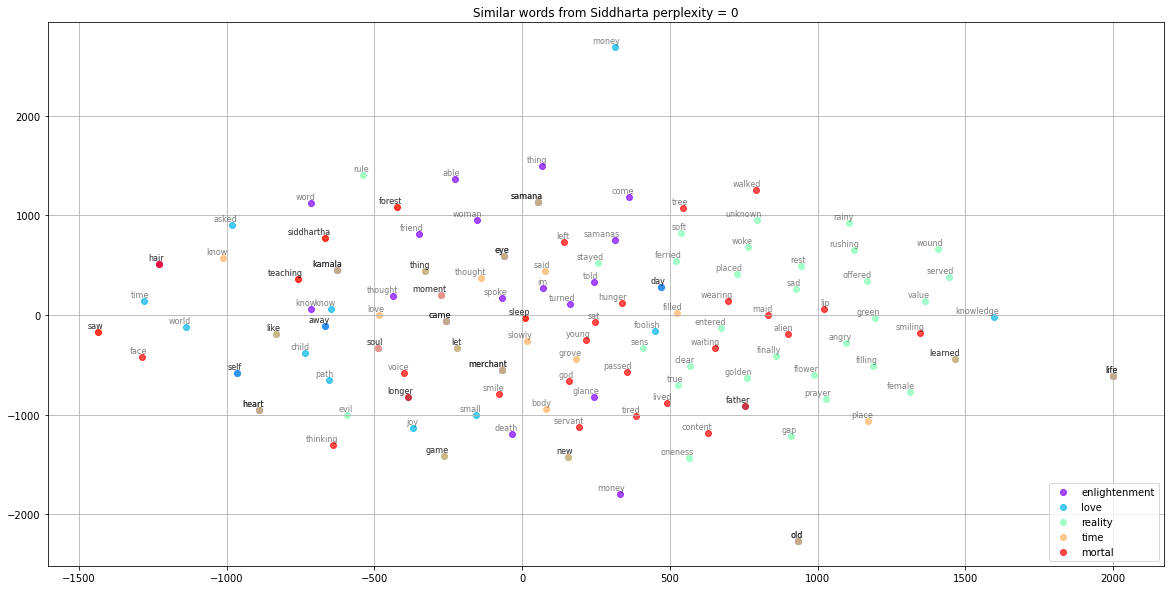

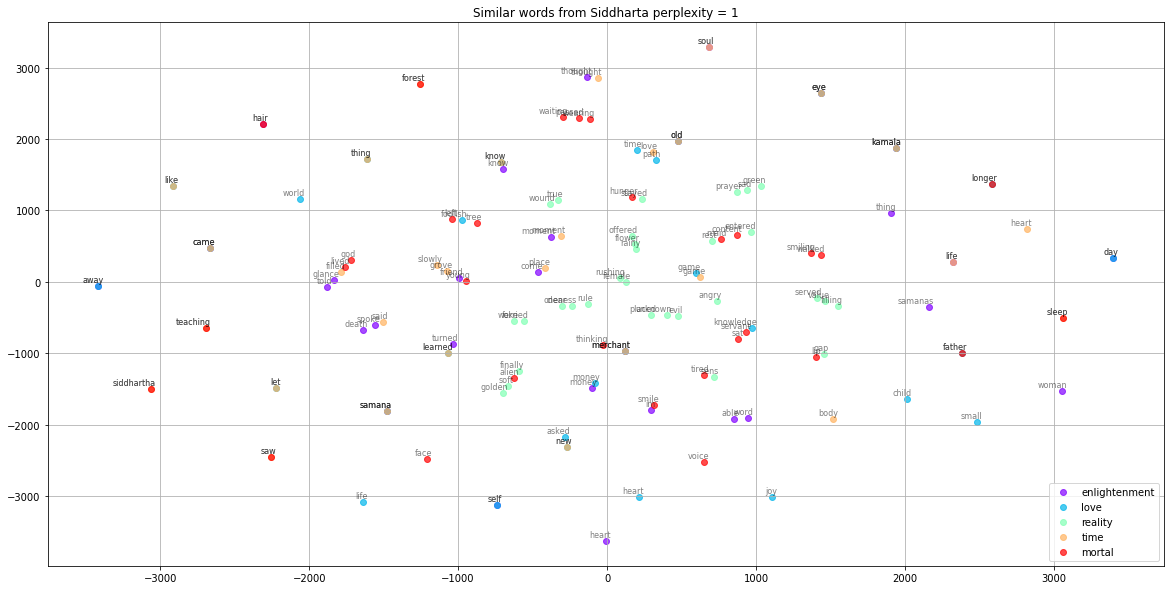

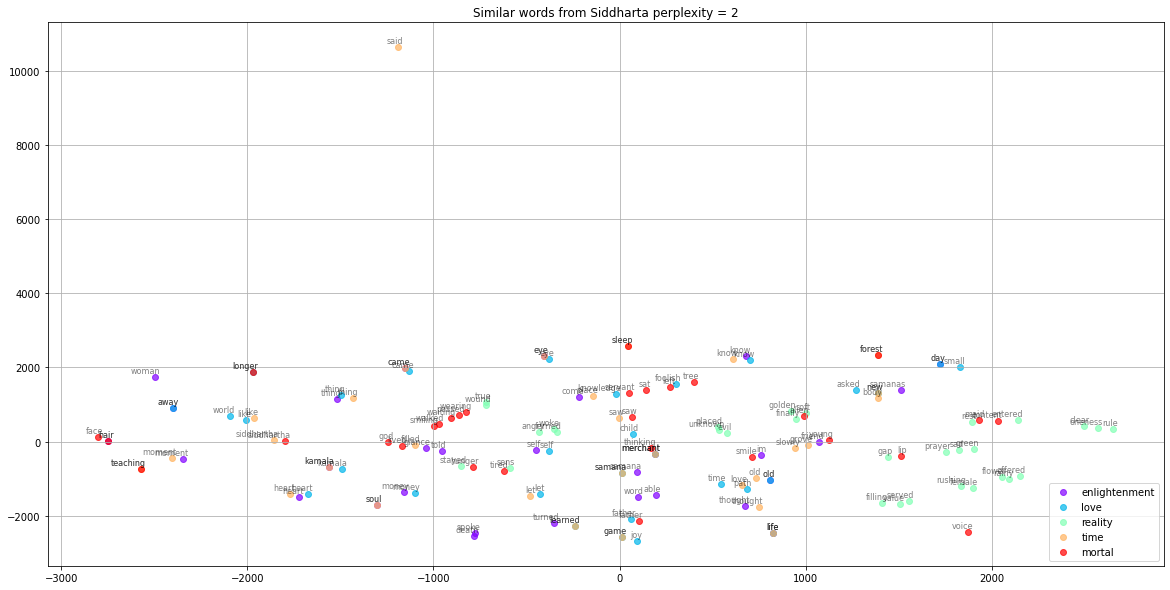

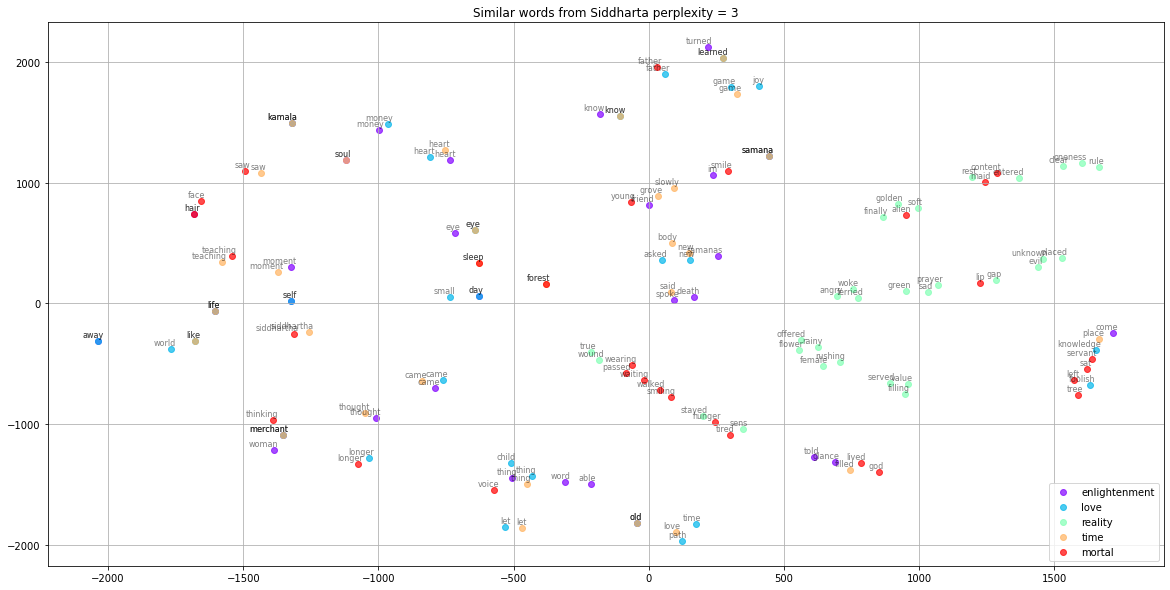

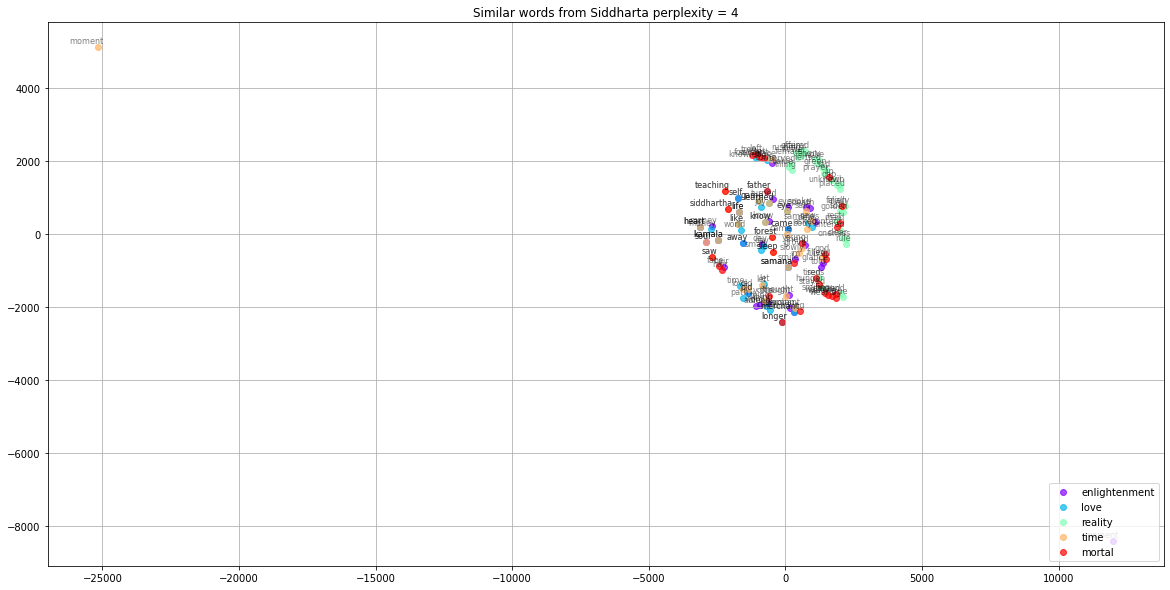

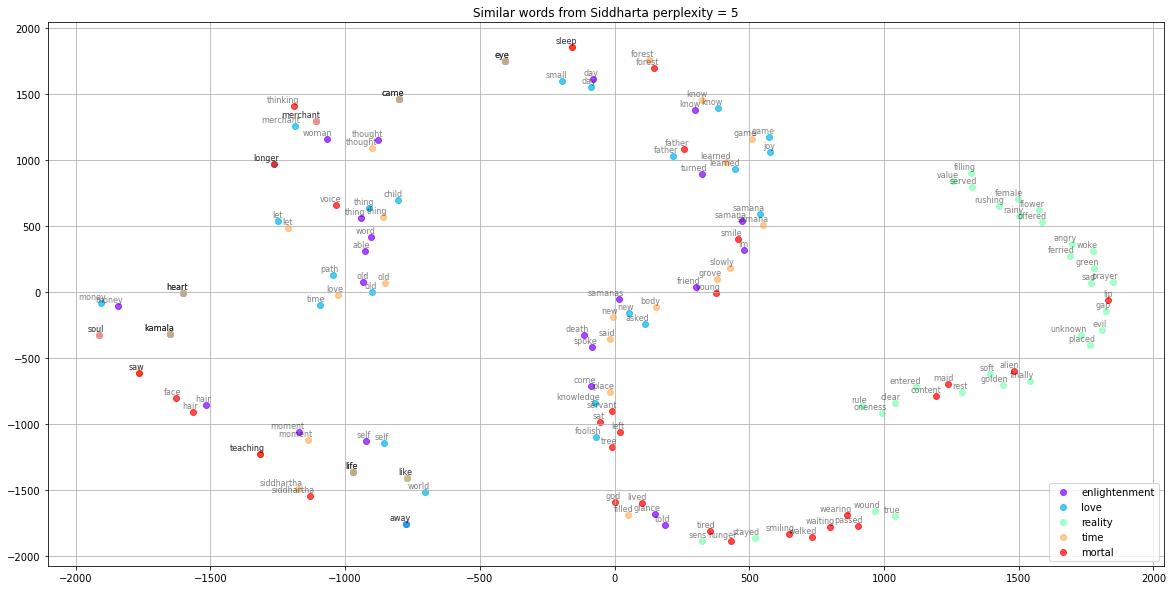

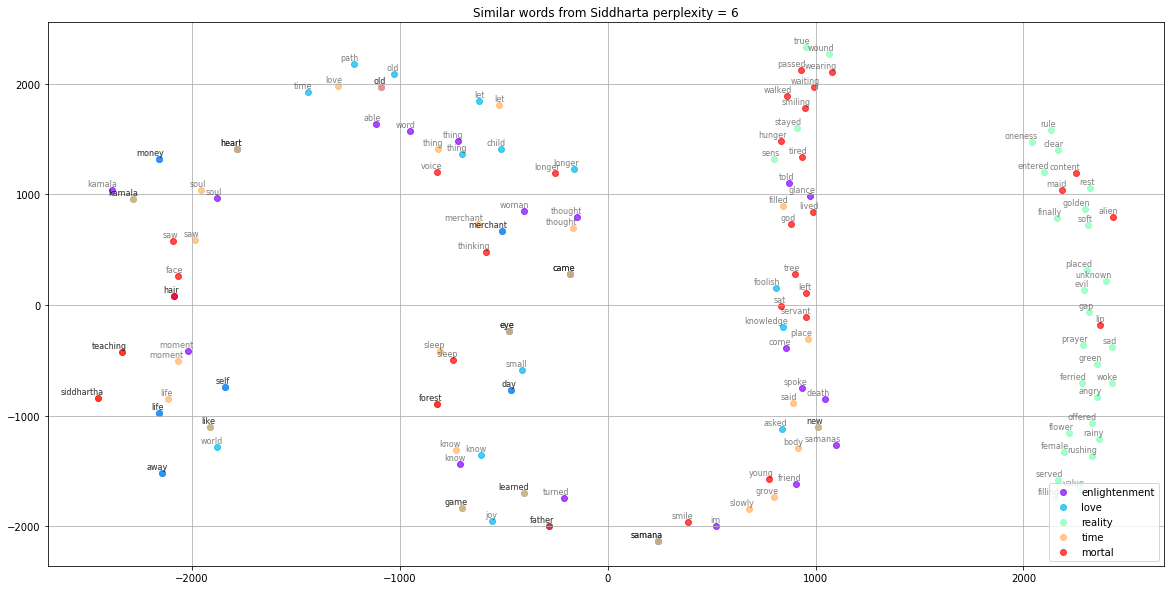

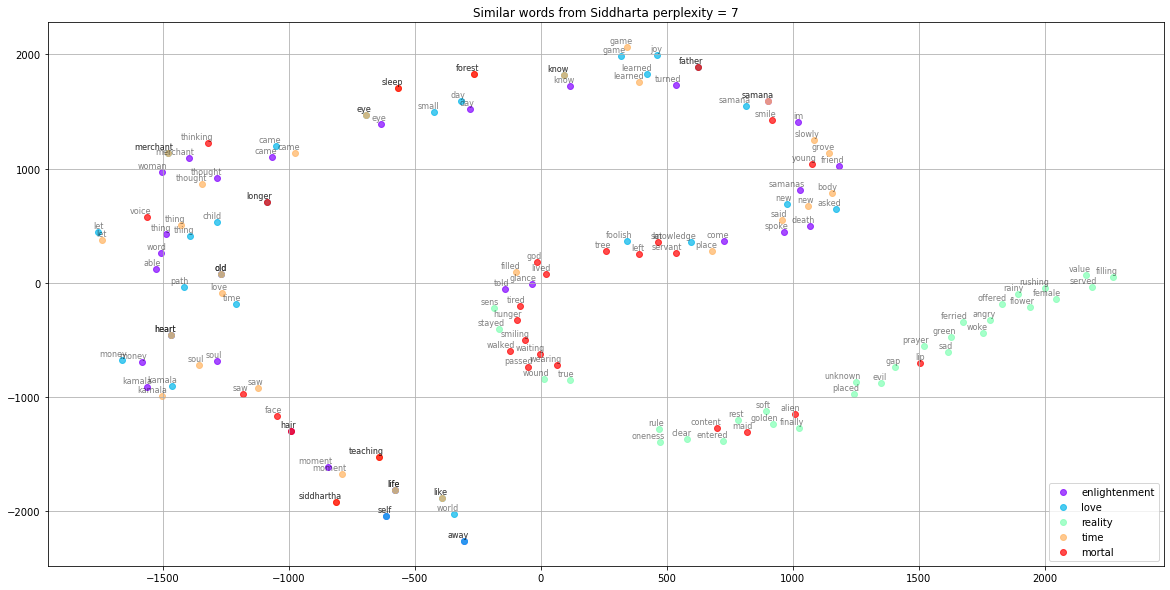

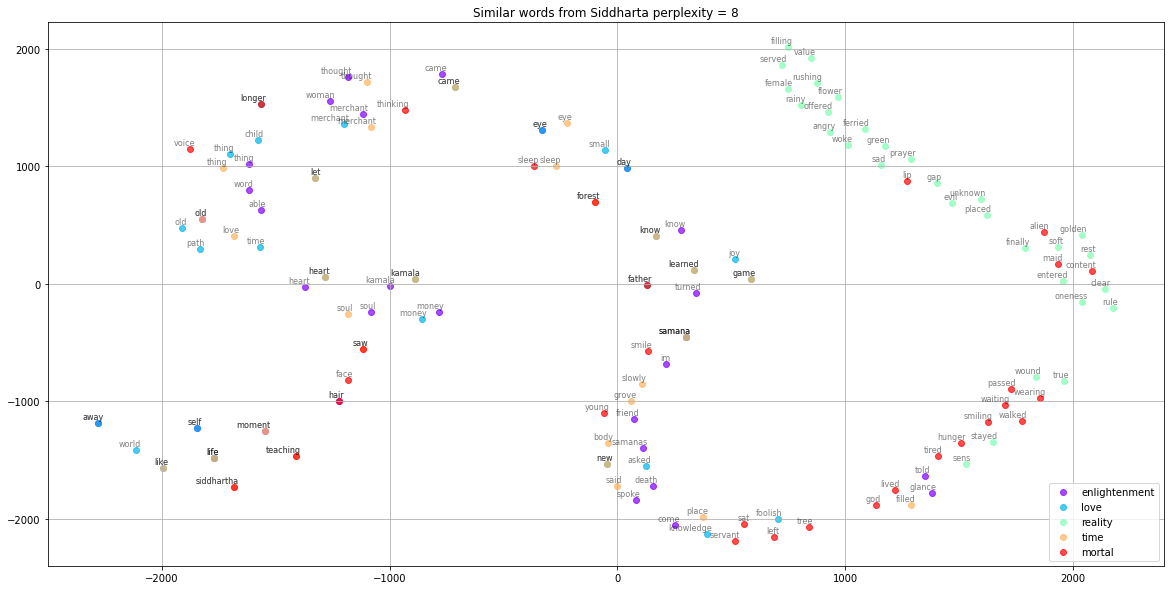

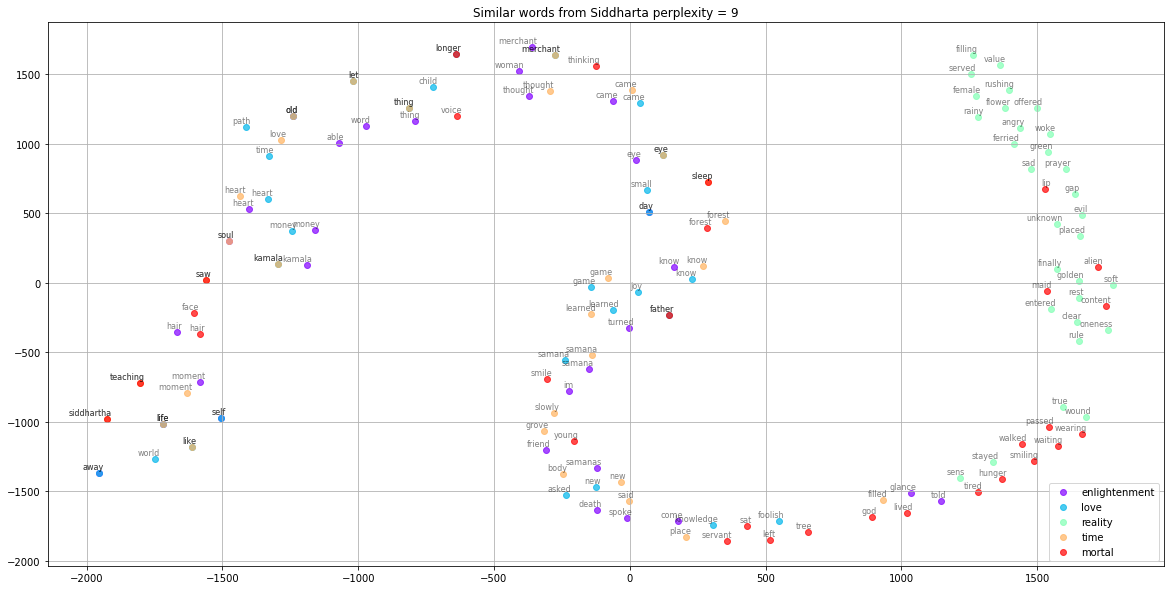

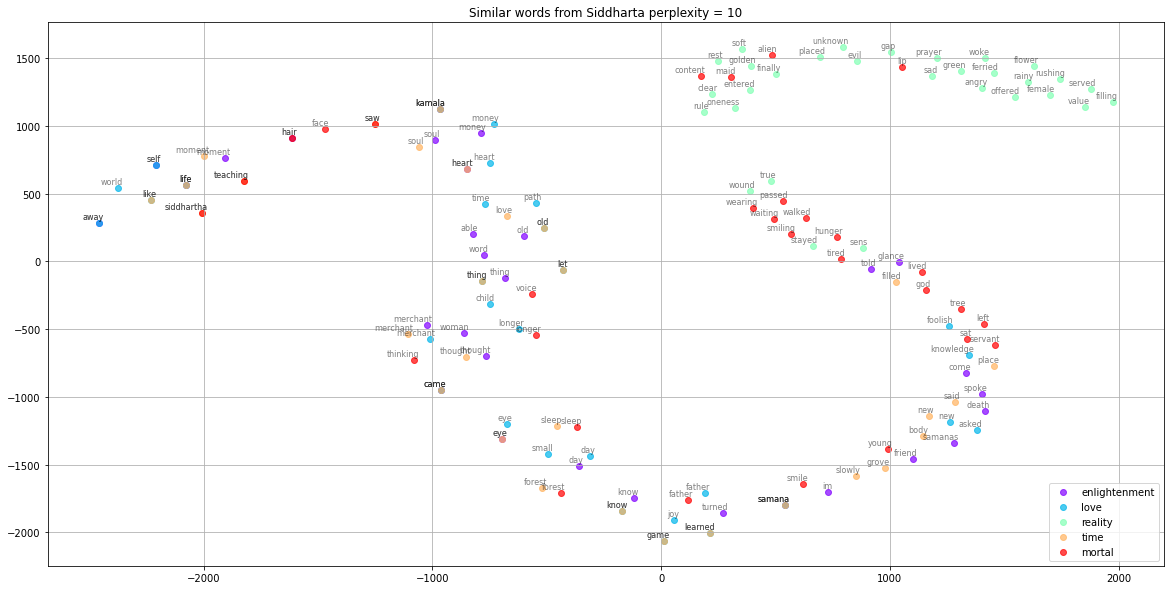

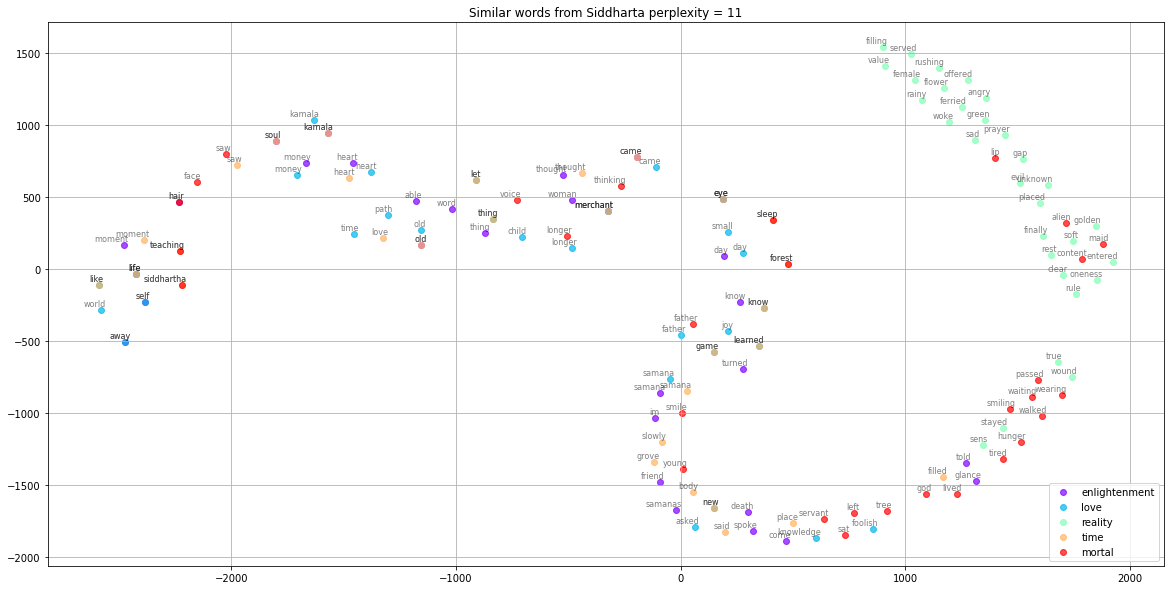

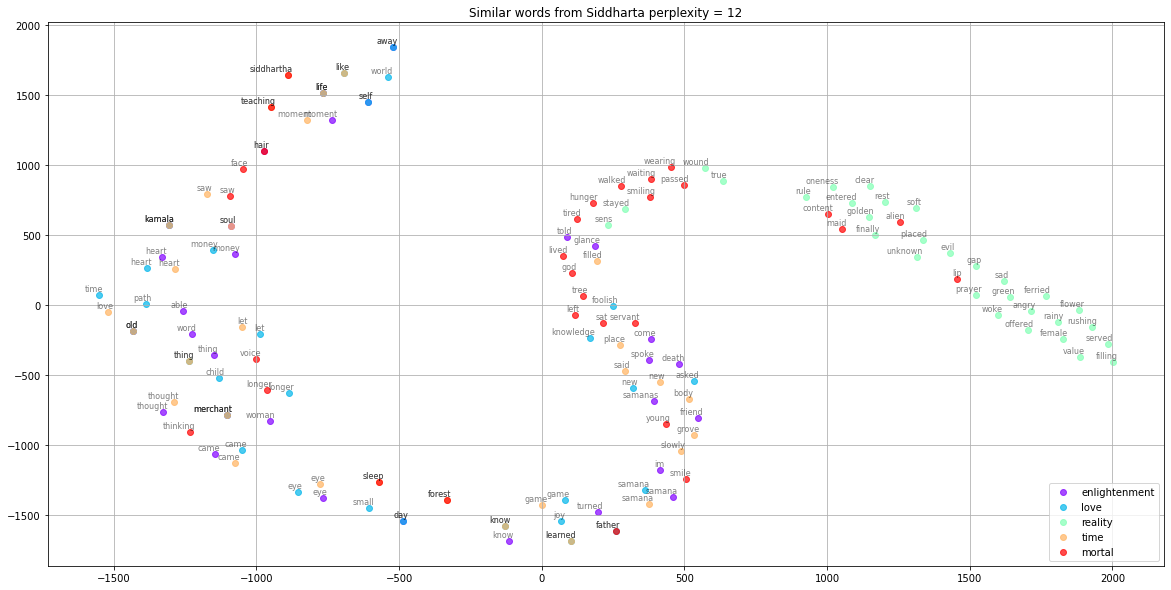

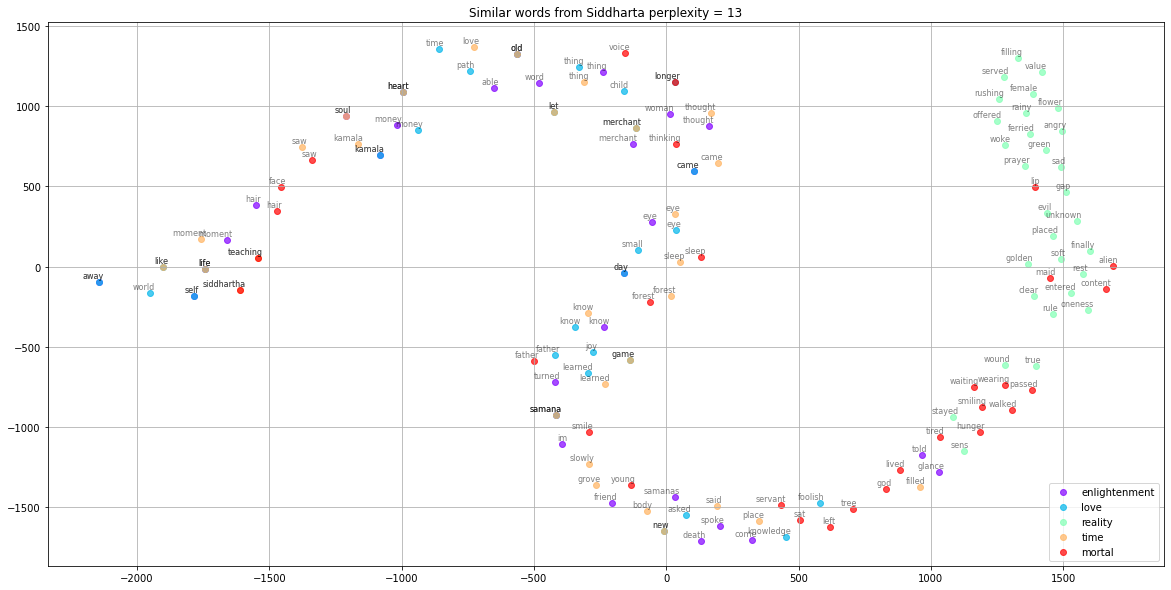

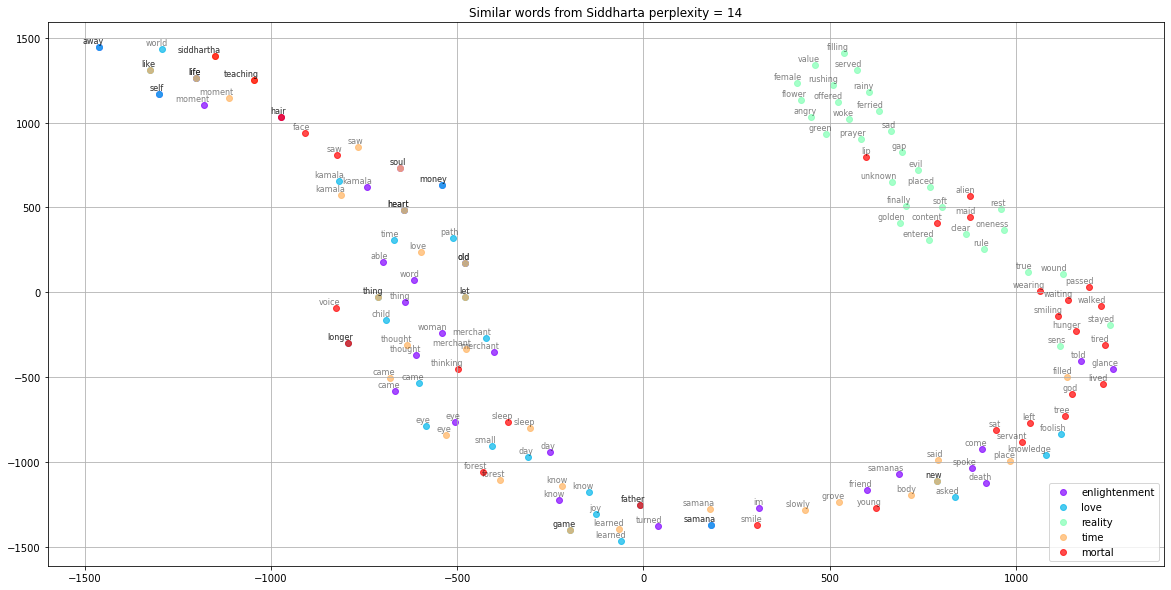

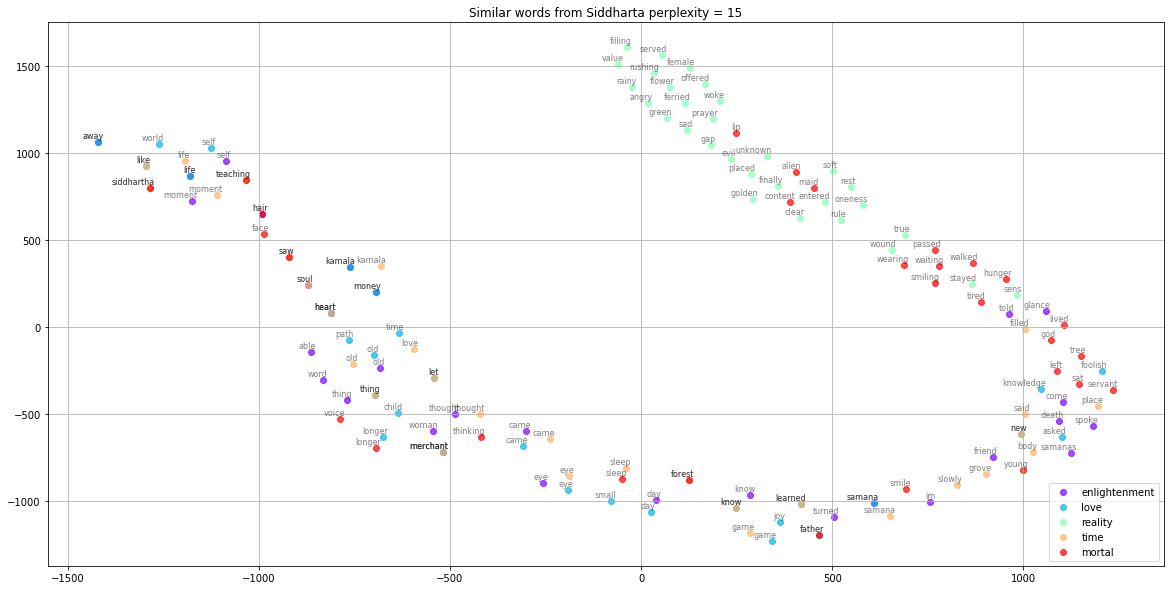

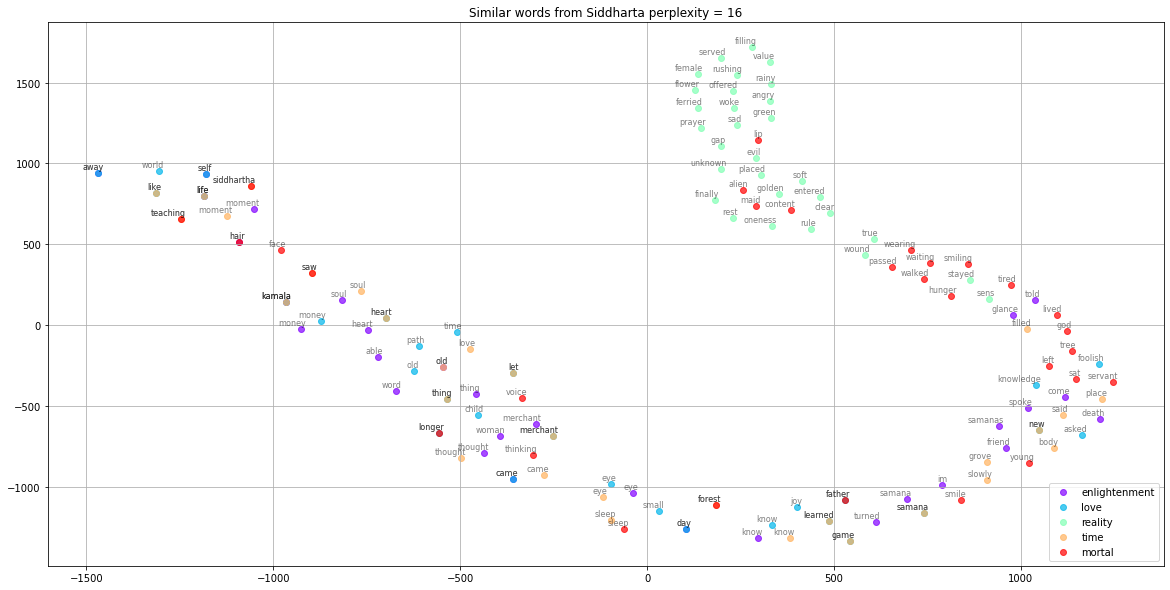

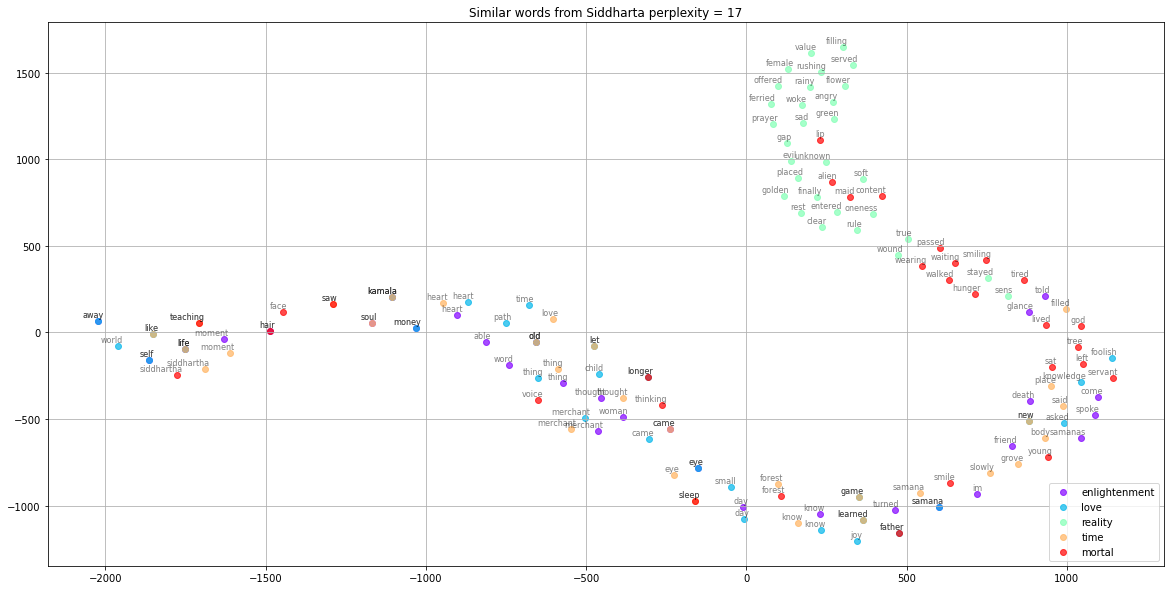

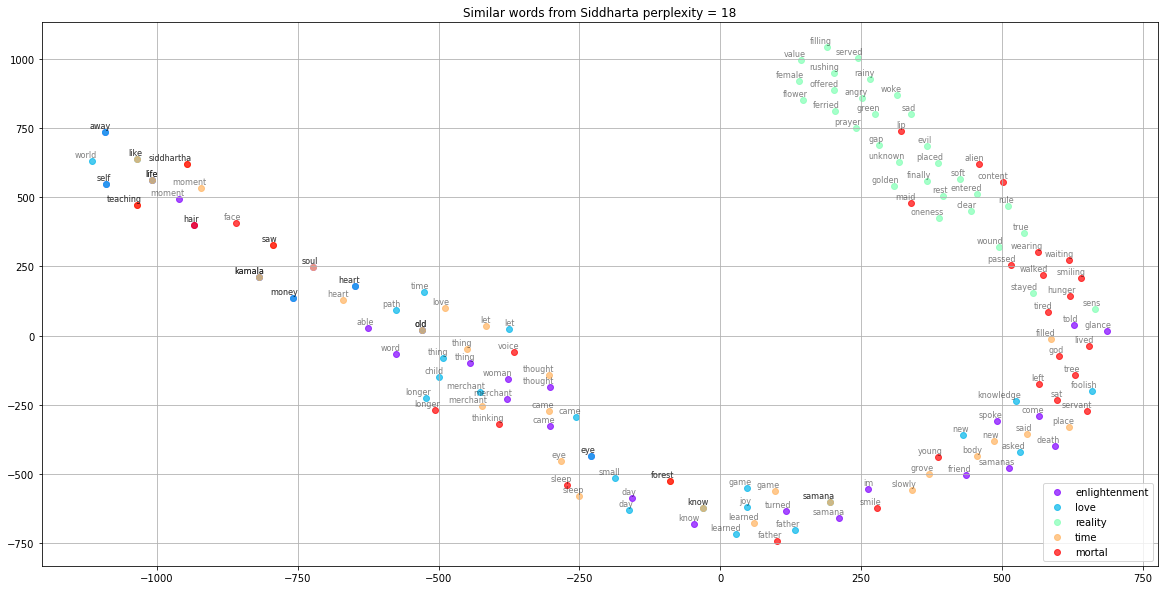

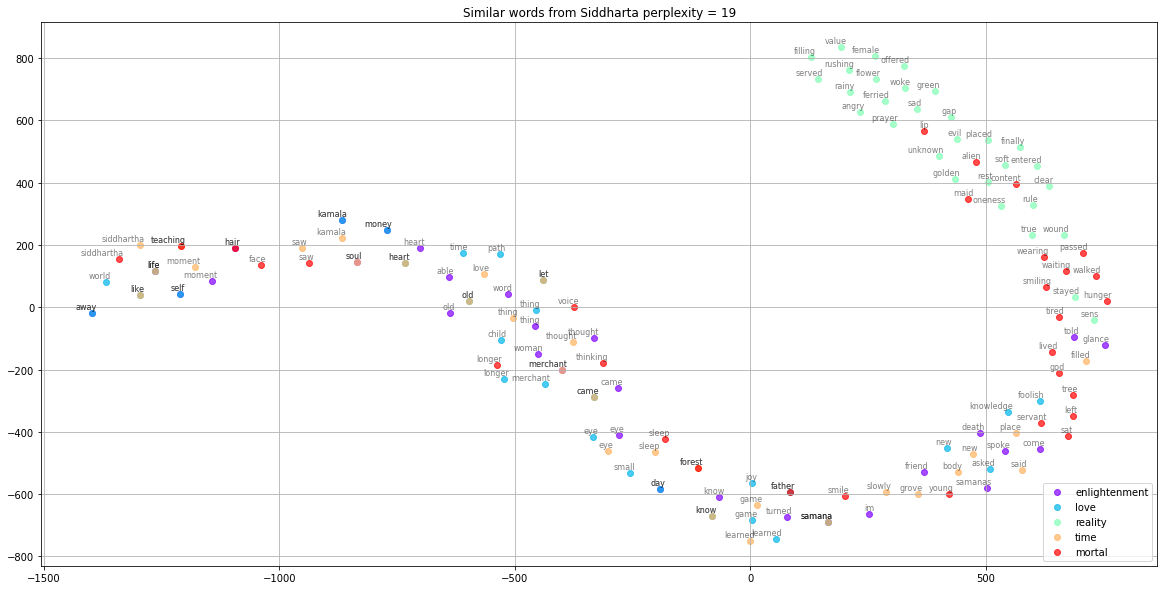

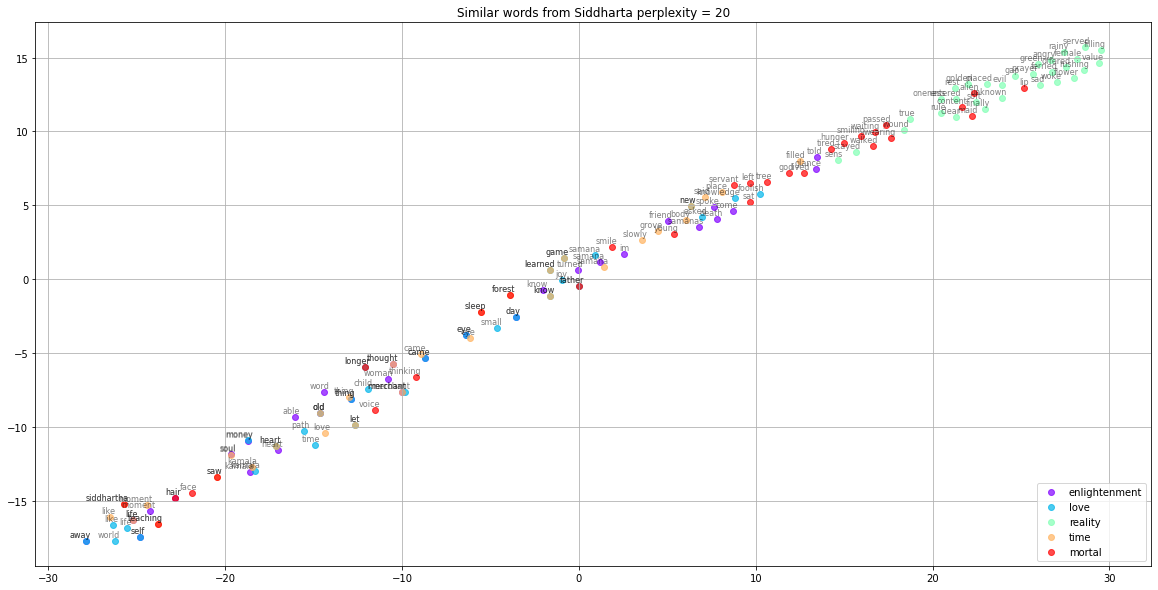

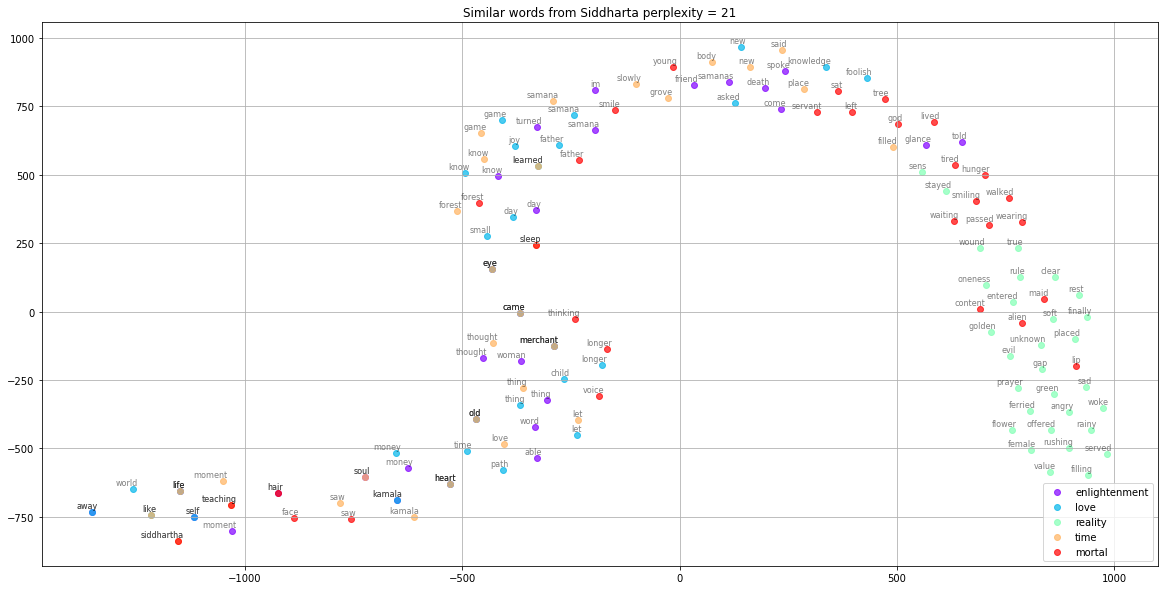

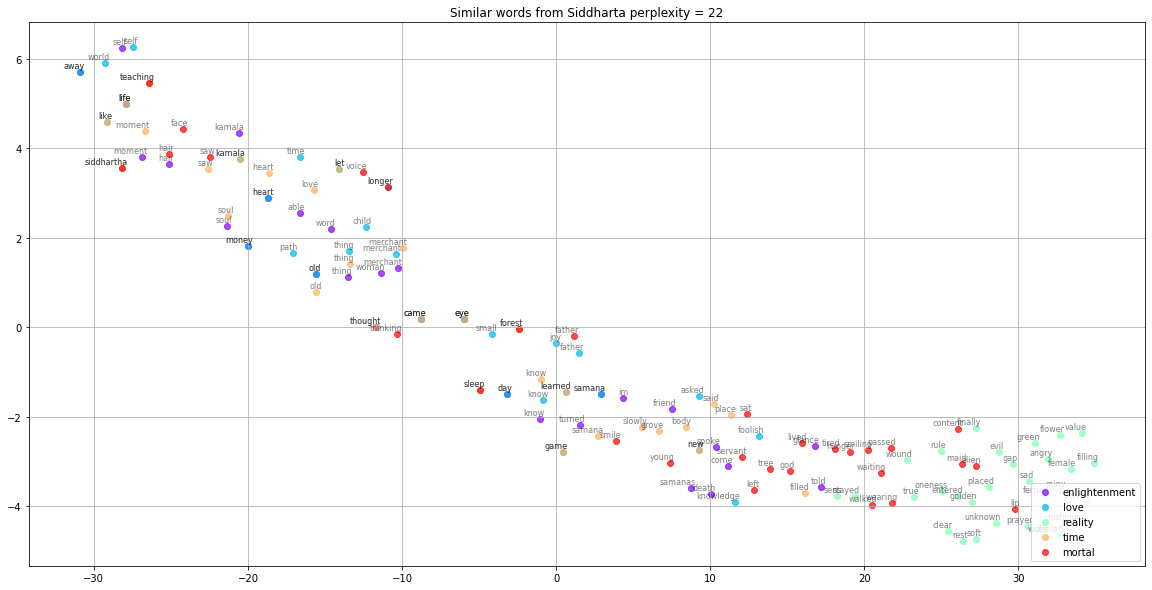

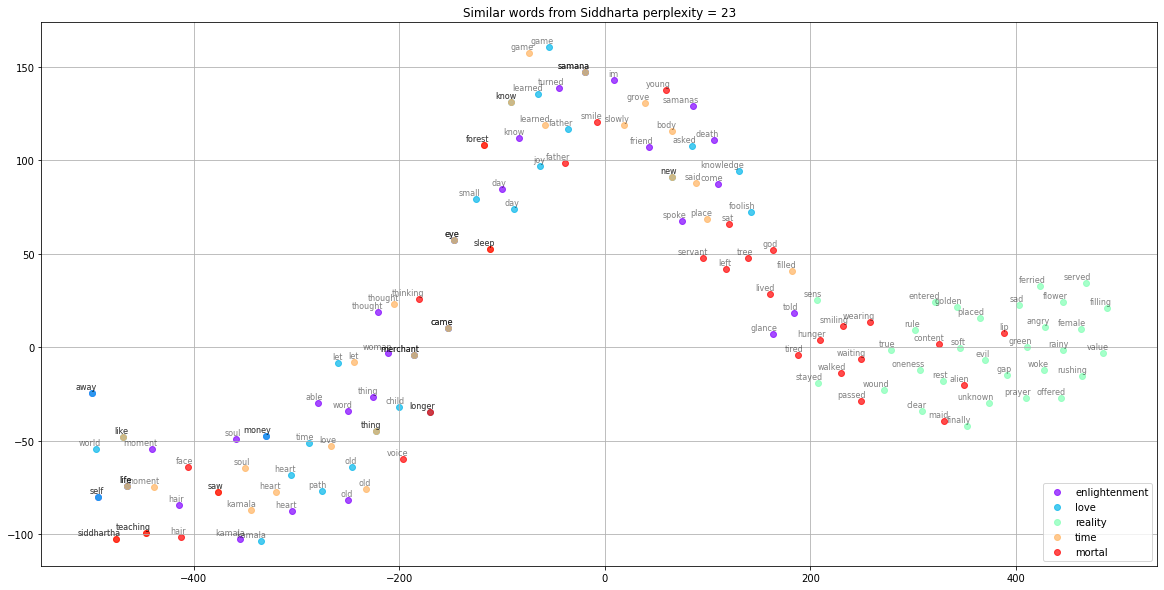

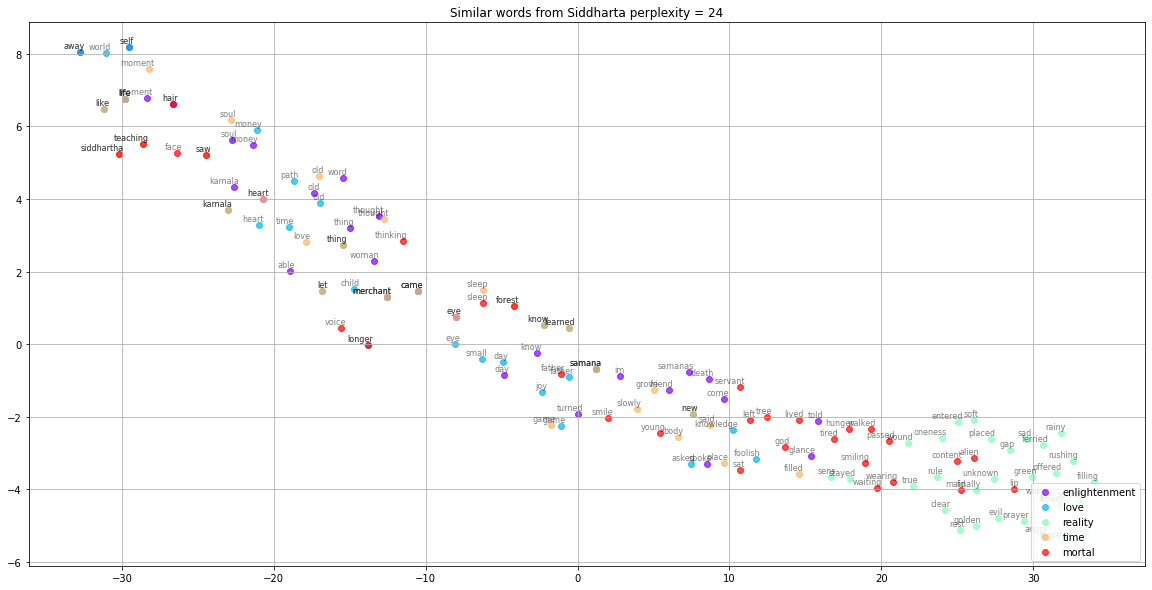

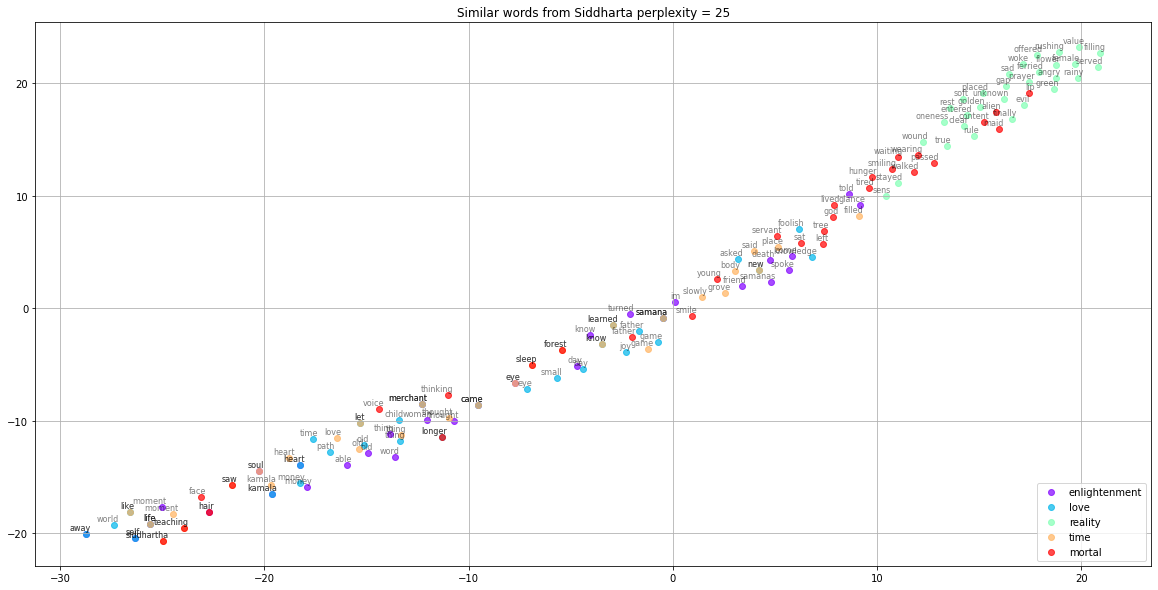

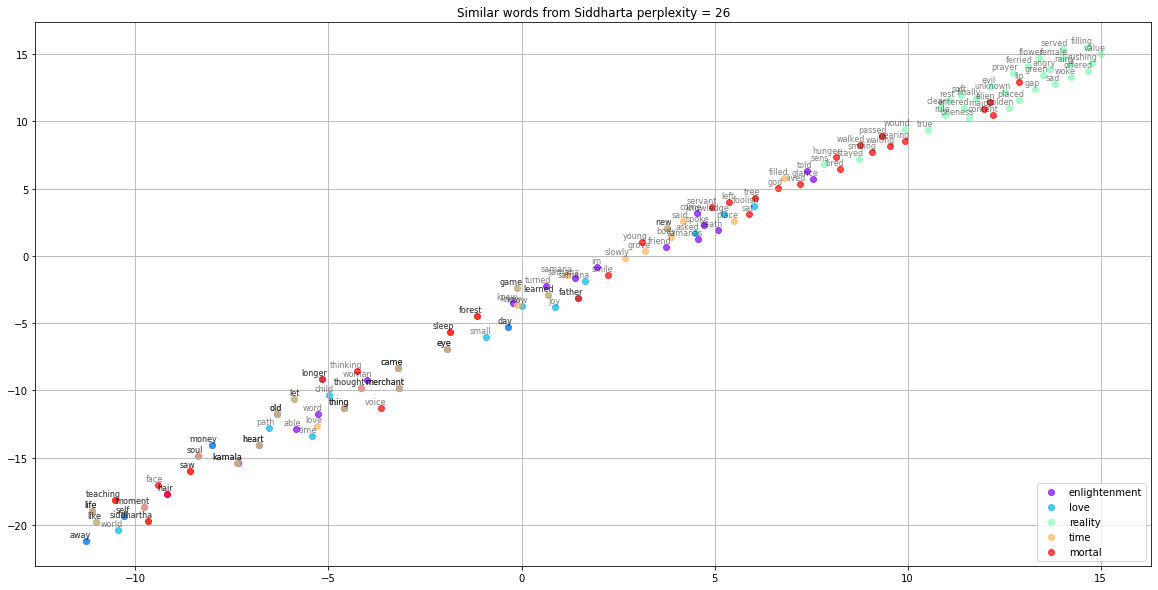

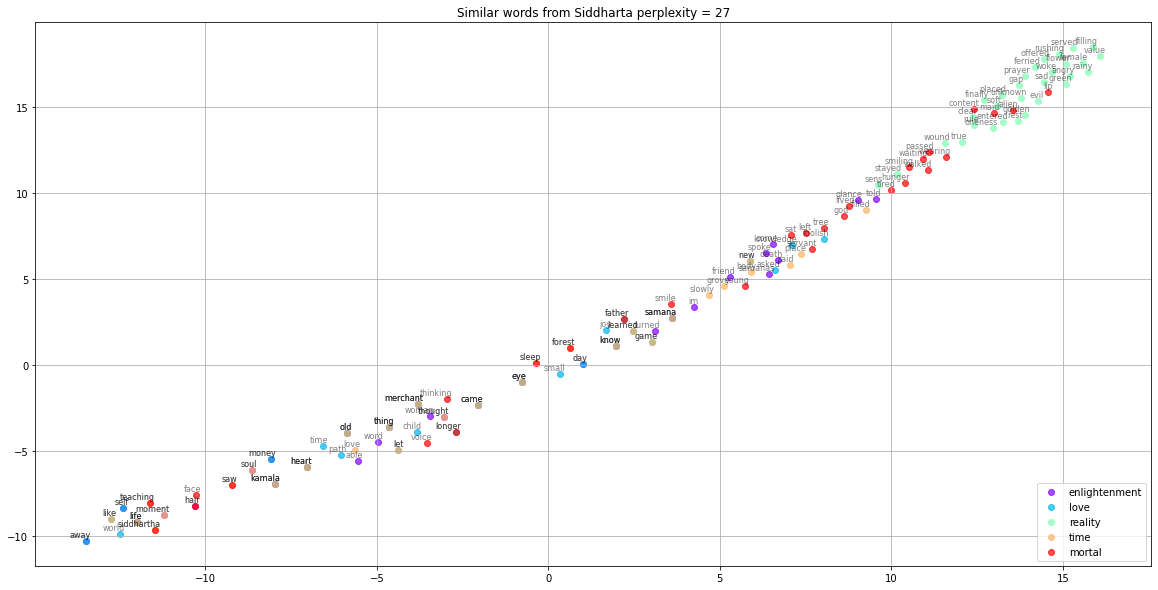

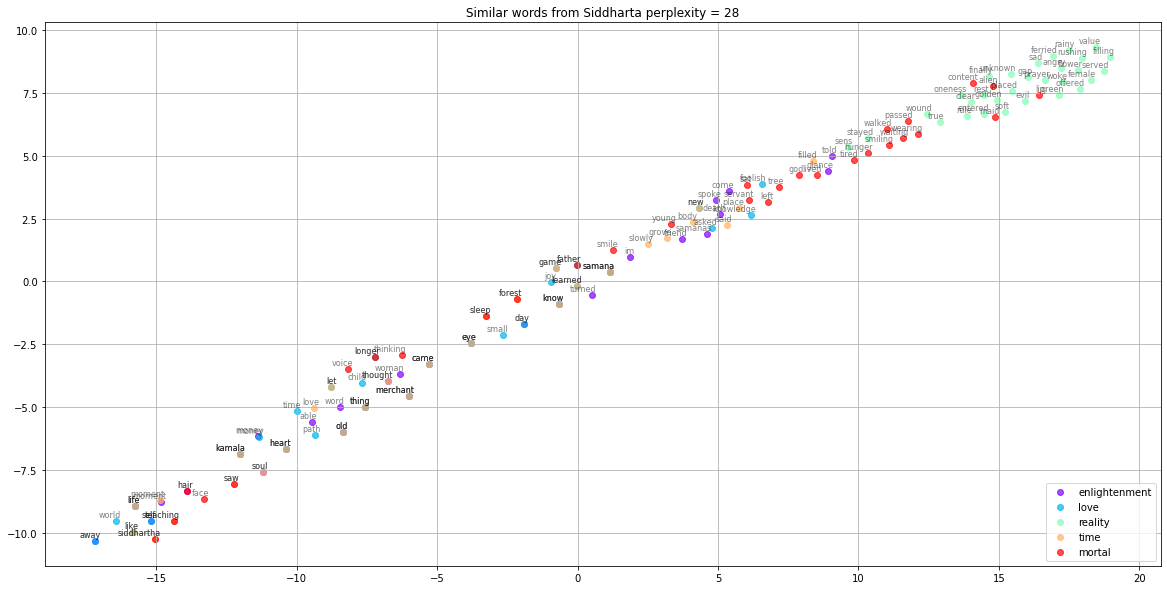

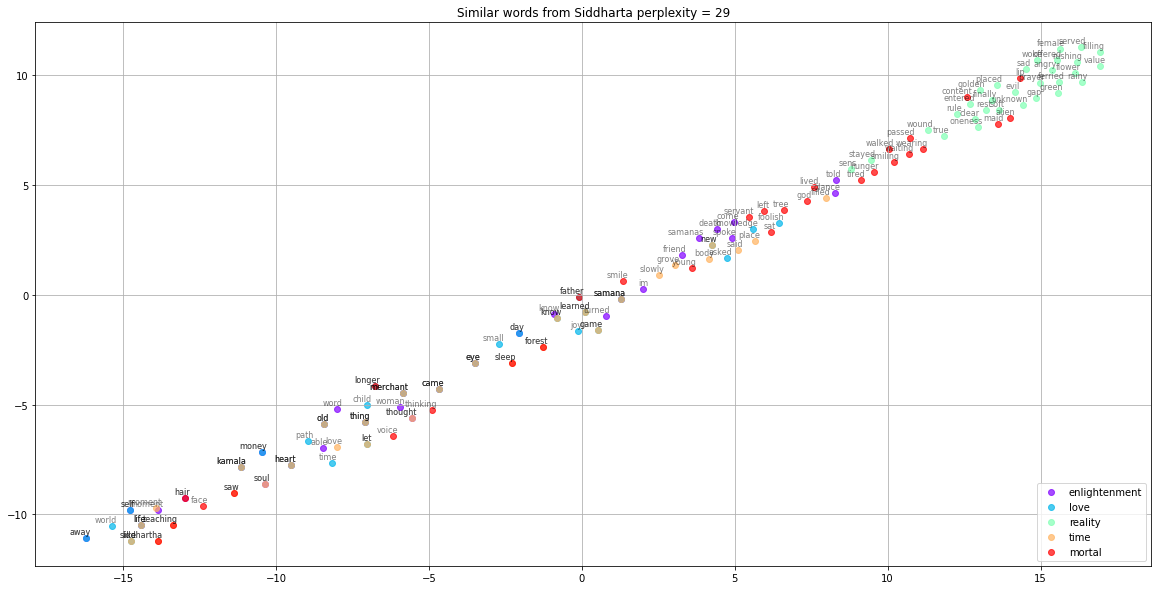

In [32]:
for i in range(30):
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=i, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

  tsne_plot_similar_words(f'Similar words from Siddharta perplexity = {i}', keys, embeddings_en_2d, word_clusters, 0.7)

As can be seen from the series of graphs above, all anchor words, except `reality` are quite difficult to find a good cluster with. This may mean that while the results from the semi-supervised topic modelling makes common sense, the words that make up each topic are not too similar with each other. This suggests that the anchor words chosen may not be the best as it had not optimized themes with key words being most similar to each other. 

## Comparing Results with Unsupervised Modelling <a name="s5"></a>

The unsupervised LDA model led to the following results: 

`Topic 0: "like", "heart", "kamala", "siddharta", "face"`
`Topic 1: "siddharta", "thought", "govinda", "said", "path"`

These topics generated by the unsupervised model were quite difficult to find a theme in. 

By contrast, the results generated by the semi-supervised model, while still containing words which were difficult to find a topic for, had a much higher interpretability as five different topics: 

`Topic 0: enlightenment, intention, reported, specific, deepest, anathapindika, cheerful, putting, believer, closer` 

`Topic 1: love, act, committed, soft, veneration, pampered, tenderness, admiration, blind, worthy` undoubtedly relates to feelings of love. 

`Topic 2: money, shoe, reality, freshly, cracked, difficult, brushwood, fig, bracelet, clothes` 

`Topic 5: time, long, ago, harvest, known, experienced, real, exchanged, buy, pregnant`

`Topic 6: mortal, abused, served, created, defeated, letter, pride, killing, creation, discussing` 

had interpretable themes namely `enlightenment`, `love`, `reality`, `time`, and `mortal` were identified more easily. While it still is far from perfect, it shows a significant improvement over the unsupervised learning model. 

## Conclusions and Recommendations <a name="s6"></a>

Based on my analysis, I can come up with the following conclusions:
1. The semi-supervised Anchored CorEx provided a increased interpretability of the resulting topics as well as accuracy in grouping together words that are sensible together. 
2. The semi-supervised model performed better than the unsupervised model because of the presence of anchor words which geared the learning of the model towards a certain theme from the get-go.

For recommendations:
1. Choose better anchor words which represent core themes of the book. While the topics generated were highly interpretable, the visualization with `t-SNE` showed that these words were not very similar. This could probably be solved by choosing better lists of anchor words which can guide the model to finding more similar words to represent a topic. 

